In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordle_base_15k import run_simulations as rl_base
from wordle_cluster_15k import run_simulations as rl_cluster
from wordle_cluster_2k import run_simulations as rl_cluster_2
from wordle_greedy_search_15k import run_simulations as greed_search
from wordle_greedy_search_2k import run_simulations as greed_search_2

results = pd.DataFrame(columns=['time_taken', 'average_guesses', 'win_rate'])

for i in tqdm(range(5)):
    if i == 0:
        time_taken, average_guesses, win_rate, guesses = rl_base(learning_rate=0.1, exploration_rate=0.8, shrinkage_factor=0.8, num_simulations=1000)
        base_guesses = guesses
        results.loc[0] = [time_taken, average_guesses, win_rate]
    elif i == 1:
        time_taken, average_guesses, win_rate, guesses = rl_cluster(learning_rate=0.1, exploration_rate=0.5, number_of_cluster=6 ,shrinkage_factor=0.9, num_simulations=1000)
        cluster_guesses = guesses
        results.loc[1] = [time_taken, average_guesses, win_rate]
    elif i == 2:
        time_taken, average_guesses, win_rate, guesses = rl_cluster_2(learning_rate=0.1, exploration_rate=0.9, number_of_cluster=10, shrinkage_factor=0.9, num_simulations=1000)
        cluster_2_guesses = guesses
        results.loc[2] = [time_taken, average_guesses, win_rate]
    elif i == 3:
        time_taken, average_guesses, win_rate, guesses = greed_search(num_simulations=1000)
        greedy_search_guesses = guesses
        results.loc[3] = [time_taken, average_guesses, win_rate]
    elif i == 4:
        time_taken, average_guesses, win_rate, guesses = greed_search_2(num_simulations=1000)
        greedy_search_2_guesses = guesses
        results.loc[4] = [time_taken, average_guesses, win_rate]

results.to_csv('evaluation_results/results.csv')
np.save('evaluation_results/base_guesses.npy', base_guesses)
np.save('evaluation_results/cluster_guesses.npy', cluster_guesses)
np.save('evaluation_results/cluster_2_guesses.npy', cluster_2_guesses)
np.save('evaluation_results/greedy_search_guesses.npy', greedy_search_guesses)
np.save('evaluation_results/greedy_search_2_guesses.npy', greedy_search_2_guesses)

100%|██████████| 5/5 [07:50<00:00, 94.00s/it] 


In [2]:
results = pd.read_csv('evaluation_results/results.csv')
base_guesses = np.load('evaluation_results/base_guesses.npy')
cluster_guesses = np.load('evaluation_results/cluster_guesses.npy')
cluster_2_guesses = np.load('evaluation_results/cluster_2_guesses.npy')
greedy_search_guesses = np.load('evaluation_results/greedy_search_guesses.npy')
greedy_search_2_guesses = np.load('evaluation_results/greedy_search_2_guesses.npy')
results

,Unnamed: 0,time_taken,average_guesses,win_rate
0,0,148.559640,6.153,65.8
1,1,261.004483,4.925,88.0
2,2,10.697975,4.049,97.3
3,3,42.305436,7.066,44.9
4,4,7.302881,5.430,75.8


Text(0.5, 1.0, 'Greedy Search 2')

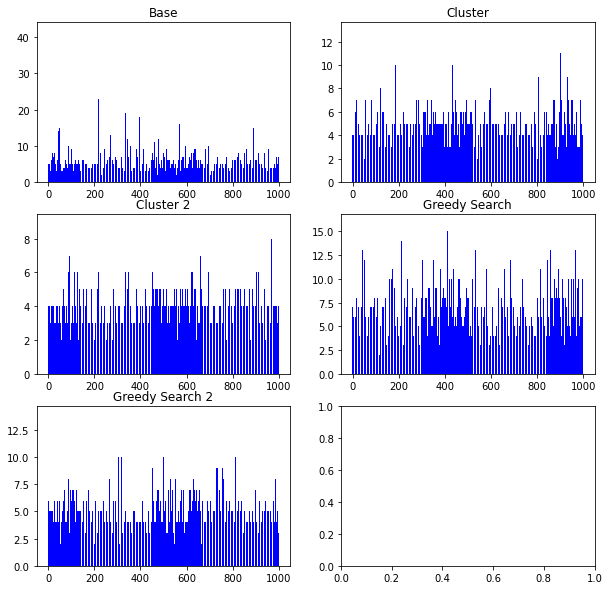

In [4]:
epochs = np.arange(1000)

fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0, 0].bar(epochs, base_guesses, color='blue')
ax[0, 0].set_title('Base')
ax[0, 1].bar(epochs, cluster_guesses, color='blue')
ax[0, 1].set_title('Cluster')
ax[1, 0].bar(epochs, cluster_2_guesses, color='blue')
ax[1, 0].set_title('Cluster 2')
ax[1, 1].bar(epochs, greedy_search_guesses, color='blue')
ax[1, 1].set_title('Greedy Search')
ax[2, 0].bar(epochs, greedy_search_2_guesses, color='blue')
ax[2, 0].set_title('Greedy Search 2')